In [1]:
symbol = input("Enter the symbol : ")

Enter the symbol : TCS


In [2]:
from nse import *
from finta import TA
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
today = datetime.now()
oneyearago = today - timedelta(days=365*10)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()

,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2013-06-21,TCS,EQ,1431.85,1408.00,1408.8,1422.25,1422.0,1404.50,1424112,2.024223e+09,1597.6,1055.0
1,2013-06-24,TCS,EQ,1434.10,1400.10,1415.0,1410.70,1412.9,1422.25,944582,1.340239e+09,1597.6,1055.0
2,2013-06-25,TCS,EQ,1427.10,1380.70,1413.5,1392.30,1391.0,1410.70,930274,1.315245e+09,1597.6,1055.0
3,2013-06-26,TCS,EQ,1447.75,1381.05,1396.9,1437.70,1446.0,1392.30,1163244,1.654858e+09,1597.6,1055.0
4,2013-06-27,TCS,EQ,1497.00,1442.00,1447.8,1491.90,1485.0,1437.70,1910339,2.812118e+09,1597.6,1055.0


In [4]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price', 'Total Traded Quantity']]
df.columns = ['Date','High', 'Low', 'Open','Close', 'Volume']
df.head()

,Date,High,Low,Open,Close,Volume
0,2013-06-21,1431.85,1408.00,1408.8,1422.25,1424112
1,2013-06-24,1434.10,1400.10,1415.0,1410.70,944582
2,2013-06-25,1427.10,1380.70,1413.5,1392.30,930274
3,2013-06-26,1447.75,1381.05,1396.9,1437.70,1163244
4,2013-06-27,1497.00,1442.00,1447.8,1491.90,1910339


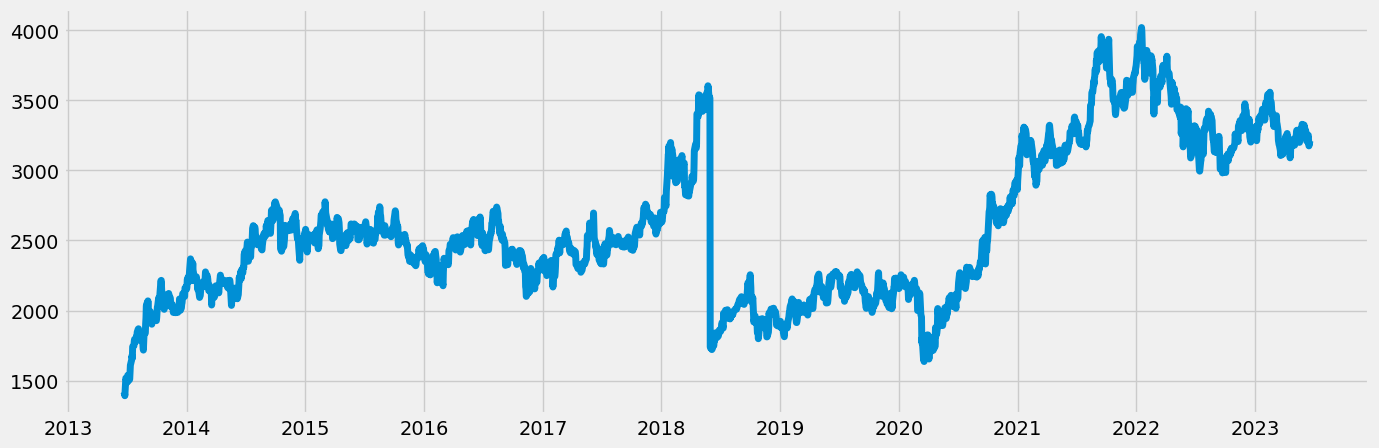

In [5]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df['Date'],df['Close'],label="Close", linestyle="-", linewidth=5)

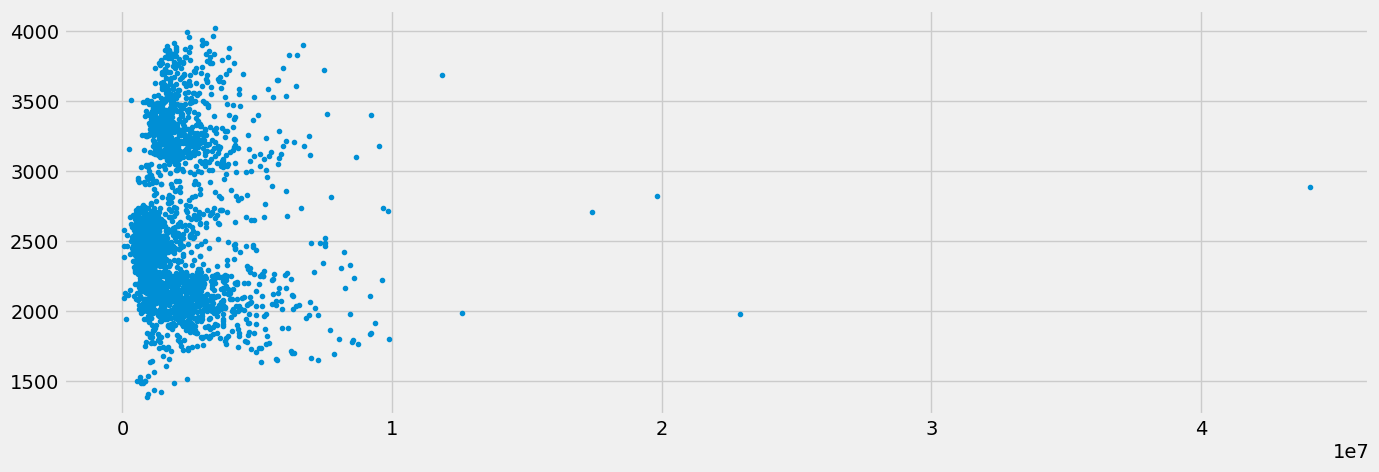

In [6]:
plt.plot(df['Volume'],df['Close'],linestyle="", marker=".")

In [7]:
def on_balance_volume_indicator(stock_df):
    new_df = pd.DataFrame({})
    new_df = stock_df[['Close']].copy()

    new_balance_volume = [0]
    tally = 0

    for i in range(1, len(new_df)):
        if (stock_df['Close'][i] > stock_df['Close'][i - 1]):
            tally += stock_df['Volume'][i]
        elif (stock_df['Close'][i] < stock_df['Close'][i - 1]):
            tally -= stock_df['Volume'][i]
        new_balance_volume.append(tally)

    new_df['OnBalanceVolume'] = new_balance_volume
    minimum = min(new_df['OnBalanceVolume'])

    new_df['OnBalanceVolume'] = new_df['OnBalanceVolume'] - minimum
    new_df['OnBalanceVolume'] = (new_df['OnBalanceVolume']+1).transform(np.log)

    return new_df

def add_technical_indicators(stock_df):
    edited_df = pd.DataFrame()

    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df.head()

    ema = TA.EMA(edited_df)
    bb = TA.BBANDS(edited_df)

    stock_df['EMA'] = ema.copy()

    #Adding of features to the dataframe
    new_df = pd.concat([stock_df, bb], axis = 1)

    #Filling of missing data as Bollinger Bands is based on a 21 day EMA

    # TODO: Uncomment
#     for i in range(19):
#         new_df['BB_MIDDLE'][i] = new_df.loc[i, 'EMA']
    
#         if i != 0:
#             higher = new_df.loc[i, 'BB_MIDDLE'] + 2 * new_df['Close'].rolling(i + 1).std()[i]
#             lower = new_df.loc[i, 'BB_MIDDLE'] - 2 * new_df['Close'].rolling(i + 1).std()[i]
#             new_df['BB_UPPER'][i] = higher
#             new_df['BB_LOWER'][i] = lower
#         else:
#             new_df['BB_UPPER'][i] = new_df.loc[i, 'BB_MIDDLE']
#             new_df['BB_LOWER'][i] = new_df.loc[i, 'BB_MIDDLE']
    
    new_df.dropna()
            
    new_df = on_balance_volume_indicator(new_df)
    
    return new_df

In [8]:
def train_test_split_preparation(new_df, train_split):
    new_df = new_df.loc[1:]
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]

    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])

    #normalise the data
    # We do a fit_transform on the train_data in order to ensure that all trained data is scaled between 0 and 1. 
    # After that, we do a .transform on the test_data to transform the test data based on the normalisation of the trained data.

    normaliser = preprocessing.MinMaxScaler()
    train_normalised_data = normaliser.fit_transform(train_data)

    test_normalised_data = normaliser.transform(test_data)

    X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    #expand_dims is used to prepare the dataset for the LSTM model
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    next_day_close_values = np.array([train_data['Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    #Fit a normaliser such that we can .inverse_fit later on the output
    y_normaliser.fit(next_day_close_values)

     
    X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    

    y_test = np.array([test_data['Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return X_train, y_train, X_test, y_test, y_normaliser

In [9]:
train_split = 0.7
history_points = 21

new_df = add_technical_indicators(df)

X_train, y_train, X_test, y_test, y_reverse_normaliser = train_test_split_preparation(new_df, train_split)


In [10]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from sklearn.metrics import mean_squared_error
tf.random.set_seed(20)
np.random.seed(10)

In [11]:
lstm_input = Input(shape=(history_points, 2), name='lstm_input')

inputs = LSTM(21, name='first_layer')(lstm_input)
inputs = Dense(16, name='first_dense_layer')(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr = 0.0008)

model.compile(optimizer=adam, loss='mse')
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

/home/matter/.local/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
103/103 [==============================] - 11s 35ms/step - loss: 0.0074 - val_loss: 9.5087e-04
Epoch 2/30
103/103 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 9.7723e-04
Epoch 3/30
103/103 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 8.5379e-04
Epoch 4/30
103/103 [==============================] - 2s 18ms/step - loss: 0.0017 - val_loss: 7.2621e-04
Epoch 5/30
103/103 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 6.6341e-04
Epoch 6/30
103/103 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 6.8819e-04
Epoch 7/30
103/103 [==============================] - 2s 17ms/step - loss: 0.0013 - val_loss: 5.9038e-04
Epoch 8/30
103/103 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 5.5768e-04
Epoch 9/30
103/103 [==============================] - 2s 18ms/step - loss: 0.0012 - val_loss: 5.7868e-04
Epoch 10/30
103/103 [==============================] -

23/23 [==============================] - 2s 9ms/step
102.01293383105684


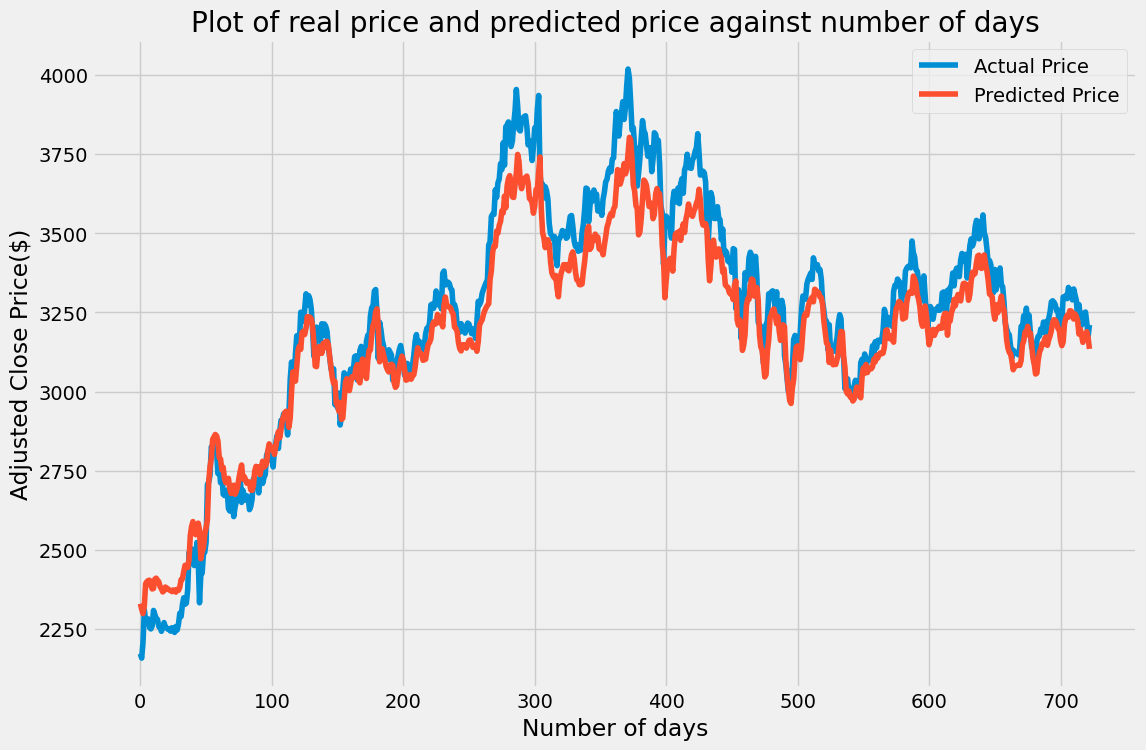

In [12]:
y_pred = model.predict(X_test)
y_pred = y_reverse_normaliser.inverse_transform(y_pred)

real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(y_pred, label='Predicted Price')

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')

plt.legend(['Actual Price', 'Predicted Price'])

#Mean squared error 

print(mean_squared_error(y_test, y_pred, squared = False))


plt.show()    

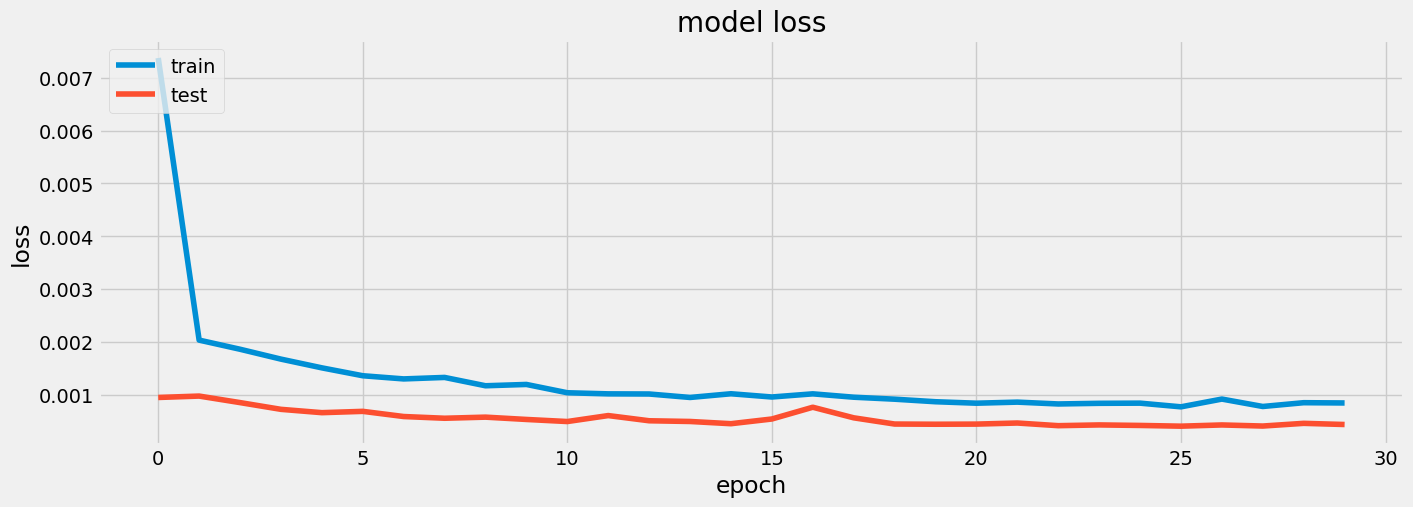

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 
# history.history.keys()